In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.random_graph_dataset as random_graph_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.gnn as gnn
import analysis.graph_metrics as graph_metrics
import analysis.mmd as mmd
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
# Create the data loader for training
node_dim = 5

dataset = random_graph_dataset.RandomGraphDataset(
    node_dim, num_items=6400,
    graph_type="sbm"
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=0  # TODO: allow multi-processing
)

### Create the model

In [4]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliOneSkipDiffuser(6, 8, (1,))  # Make input shape just 1

t_limit = 50

model = gnn.GraphLinkGAT(
    node_dim, t_limit,
    num_gnn_layers=5
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models/misc"

import model.train_model as train_model  # Import this AFTER setting environment

### Show the forward-diffusion process

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


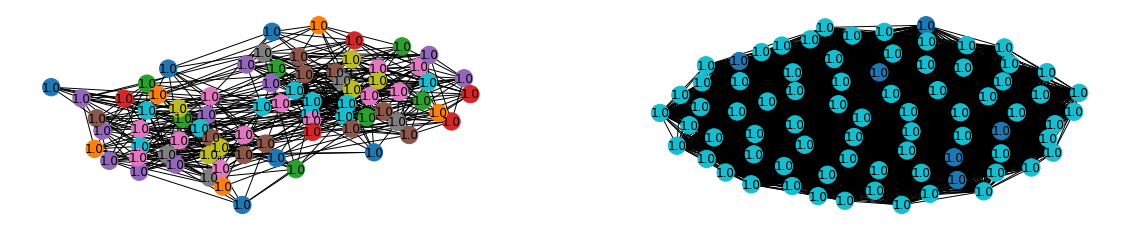

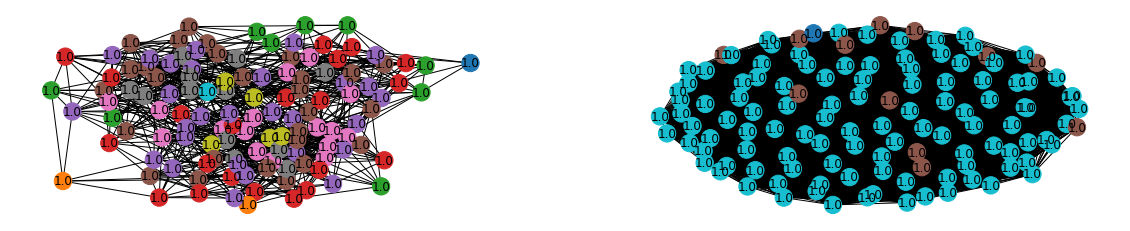

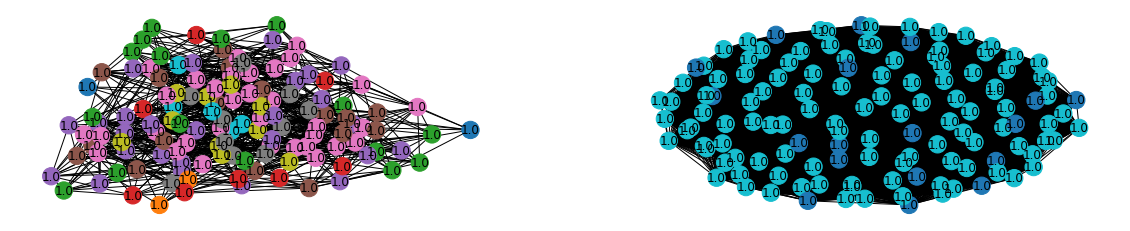

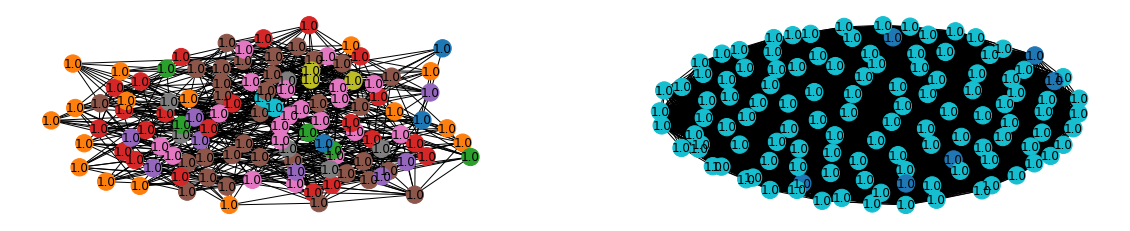

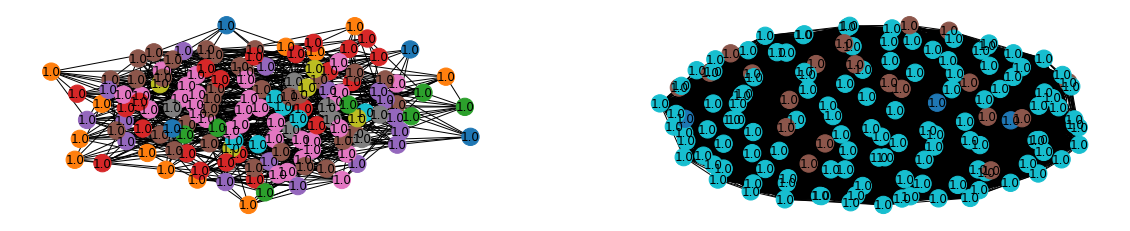

In [5]:
# Check the NetworkX graphs in a batch directly from the data loader, and
# after adding noise for a long time
data = next(iter(data_loader))

graphs_0 = graph_conversions.split_pyg_data_to_nx_graphs(data)

e0, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)
t_e = torch.tile(torch.tensor([t_limit], device=DEVICE), (e0.shape[0],))
et = diffuser.forward(e0[:, None], t_e, return_posterior=False)[:, 0]  # Do the noising on E x 1 tensors
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)

graphs_t = graph_conversions.split_pyg_data_to_nx_graphs(data)

for i in np.random.choice(len(graphs_0), replace=False, size=min(5, len(graphs_0))):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    degrees = dict(graphs_0[i].degree())
    node_degrees = [degrees[n] for n in range(len(graphs_0[i]))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(graphs_0[i]), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(graphs_0[i], ax=ax[0], node_color=node_degrees, labels=labels, cmap="tab10")
    degrees = dict(graphs_t[i].degree())
    node_degrees = [degrees[n] for n in range(len(graphs_0[i]))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(graphs_t[i]), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(graphs_t[i], ax=ax[1], node_color=node_degrees, labels=labels, cmap="tab10")
    plt.show()

  0%|          | 0/49 [00:00<?, ?it/s]

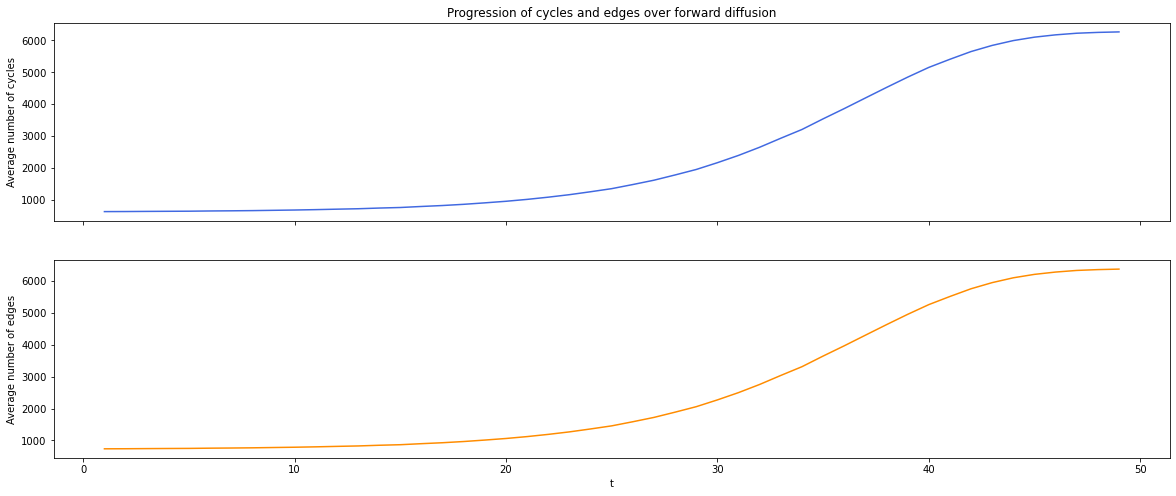

In [6]:
# Check progression of the number of cycles and edges
t_vals = np.arange(1, t_limit)
num_cycles = np.empty((len(t_vals), data_loader.batch_size))
num_edges = np.empty((len(t_vals), data_loader.batch_size))
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = diffuser.forward(e0[None], t_tens, return_posterior=False)[0]  # Do the noising on 1 x E tensors
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`
    
    # Convert to a list of NetworkX graphs
    graphs = graph_conversions.split_pyg_data_to_nx_graphs(data)
    for j, g in enumerate(graphs):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(t_vals, np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(t_vals, np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("t")

ax[0].set_title("Progression of cycles and edges over forward diffusion")
plt.show()

  0%|          | 0/49 [00:00<?, ?it/s]

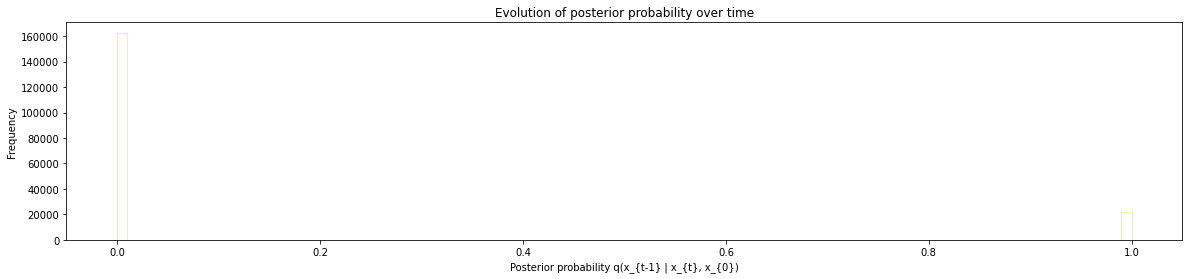

In [7]:
### Check progression of posterior probability
t_vals = np.arange(1, t_limit)
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
posterior_probs = np.empty((len(t_vals), e0.shape[0]))
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et, p = diffuser.forward(e0[None], t_tens)  # Do the noising on 1 x E tensors
    et, p = et[0], p[0]
    posterior_probs[i] = p.cpu().numpy()
    
fig, ax = plt.subplots(figsize=(20, 4))
times = np.tile(t_vals[:, None], (1, posterior_probs.shape[1]))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 100)
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs[t_i], bins=bins, histtype="step", color=cmap(t_i / len(t_vals)), alpha=0.5)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

### Train the model

In [8]:
train_model.train_ex.run(
    "train_graph_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "num_epochs": 30,
        "learning_rate": 0.001,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_graph_model'
INFO - train - Started run with ID "102"
Loss: 0.3662: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:40<00:00,  1.99it/s]


Epoch 1 average Loss: 0.3626


Loss: 0.3597: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:37<00:00,  2.05it/s]


Epoch 2 average Loss: 0.3570


Loss: 0.3547: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 3 average Loss: 0.3560


Loss: 0.3737: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 4 average Loss: 0.3563


Loss: 0.3502: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.04it/s]


Epoch 5 average Loss: 0.3553


Loss: 0.3586: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02it/s]


Epoch 6 average Loss: 0.3545


Loss: 0.3569: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 7 average Loss: 0.3519


Loss: 0.3420: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.04it/s]


Epoch 8 average Loss: 0.3538


Loss: 0.3456: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02it/s]


Epoch 9 average Loss: 0.3468


Loss: 0.3354: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:37<00:00,  2.04it/s]


Epoch 10 average Loss: 0.3374


Loss: 0.3307: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:39<00:00,  2.01it/s]


Epoch 11 average Loss: 0.3460


Loss: 0.3324: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02it/s]


Epoch 12 average Loss: 0.3314


Loss: 0.3273: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 13 average Loss: 0.3311


Loss: 0.3333: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.04it/s]


Epoch 14 average Loss: 0.3319


Loss: 0.3209: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02it/s]


Epoch 15 average Loss: 0.3301


Loss: 0.3429: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02it/s]


Epoch 16 average Loss: 0.3309


Loss: 0.3241: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.04it/s]


Epoch 17 average Loss: 0.3323


Loss: 0.3263: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02it/s]


Epoch 18 average Loss: 0.3293


Loss: 0.3260: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.04it/s]


Epoch 19 average Loss: 0.3331


Loss: 0.3264: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:39<00:00,  2.02it/s]


Epoch 20 average Loss: 0.3289


Loss: 0.3343: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02it/s]


Epoch 21 average Loss: 0.3334


Loss: 0.3269: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.04it/s]


Epoch 22 average Loss: 0.3289


Loss: 0.3187: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:39<00:00,  2.02it/s]


Epoch 23 average Loss: 0.3265


Loss: 0.3248: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.02it/s]


Epoch 24 average Loss: 0.3172


Loss: 0.3112: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 25 average Loss: 0.3149


Loss: 0.3058: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 26 average Loss: 0.3136


Loss: 0.3137: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 27 average Loss: 0.3103


Loss: 0.3115: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 28 average Loss: 0.3085


Loss: 0.3041: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]


Epoch 29 average Loss: 0.3069


Loss: 0.3058: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:38<00:00,  2.03it/s]
INFO - train - Completed after 0:49:21


Epoch 30 average Loss: 0.3061


### Show generated graphs

In [9]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")

# Sample from the prior
data = next(iter(data_loader))
edges = graph_conversions.pyg_data_to_edge_vector(data)
sampled_edges = diffuser.sample_prior(
    edges.shape[0], # Samples will be E x 1
    torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
)[:, 0]  # Shape: E
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)

samples, times = generate.generate_graph_samples(
    model, diffuser, data, t_limit=t_limit, return_all_times=True
)
times = times.cpu().numpy()
# Split samples into individual graphs
graph_samples = [
    graph_conversions.split_pyg_data_to_nx_graphs(sample)
    for sample in samples
]

Sampling some reverse trajectories


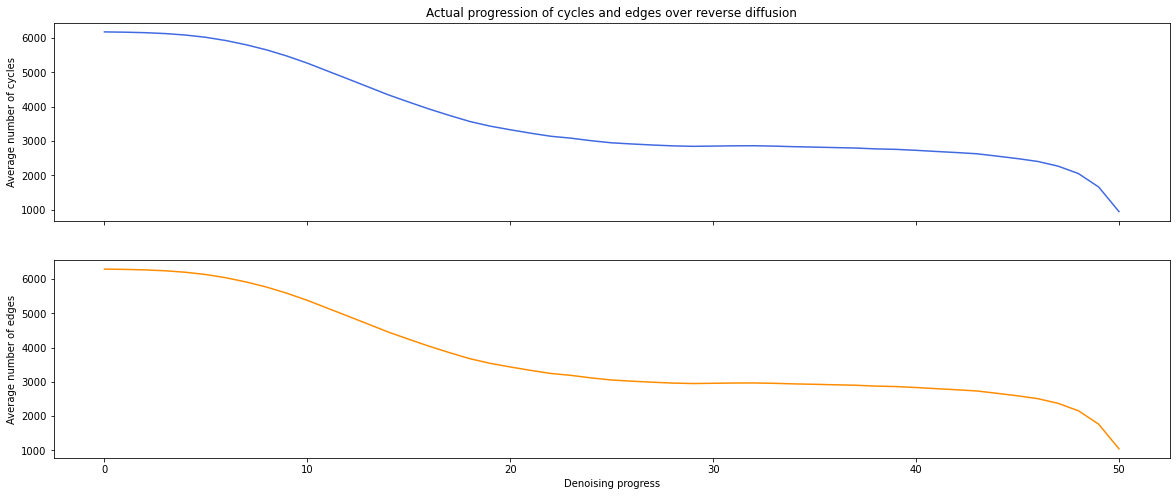

In [10]:
# Check progression of the number of cycles and edges
num_cycles = np.empty((len(graph_samples), len(graph_samples[0])))
num_edges = np.empty((len(graph_samples), len(graph_samples[0])))
for i in range(len(graph_samples)):
    for j, g in enumerate(graph_samples[i]):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(np.arange(len(graph_samples)), np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(np.arange(len(graph_samples)), np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("Denoising progress")

ax[0].set_title("Actual progression of cycles and edges over reverse diffusion")
plt.show()

0


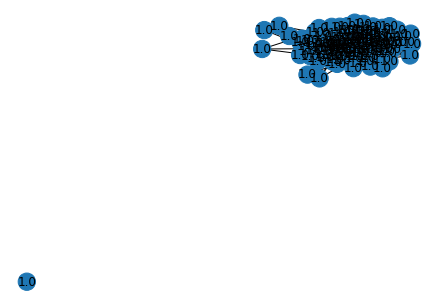

1


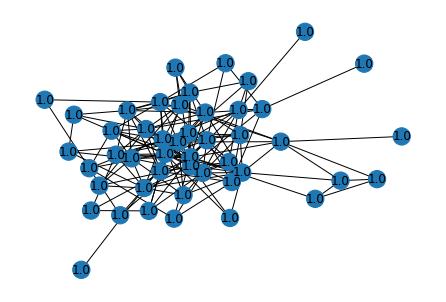

2


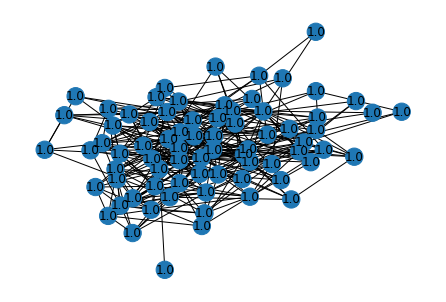

3


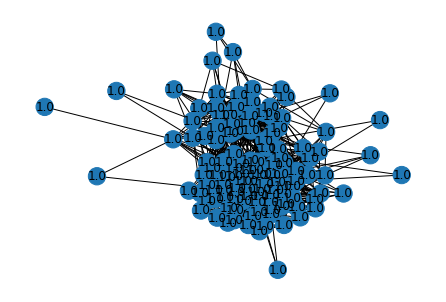

4


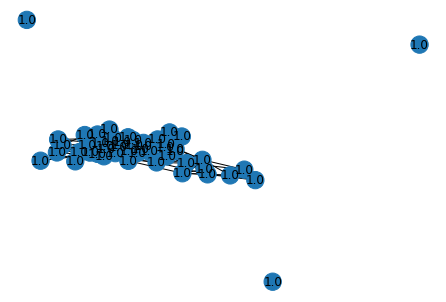

5


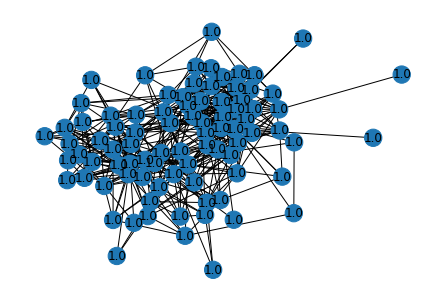

6


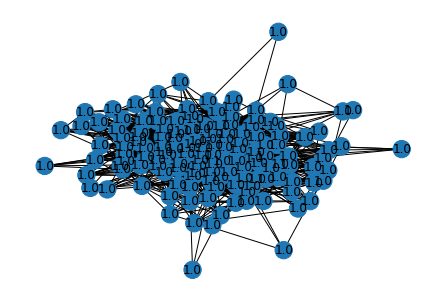

7


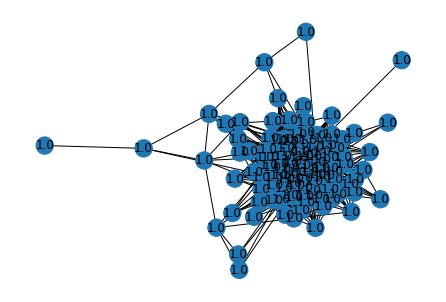

8


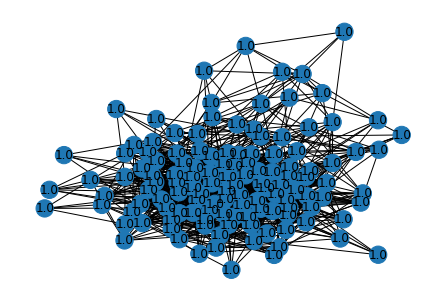

9


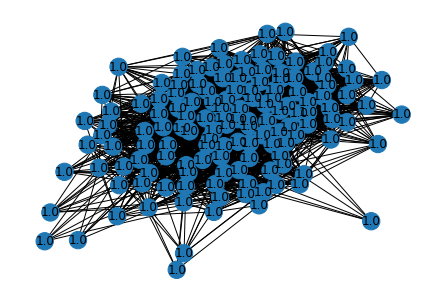

10


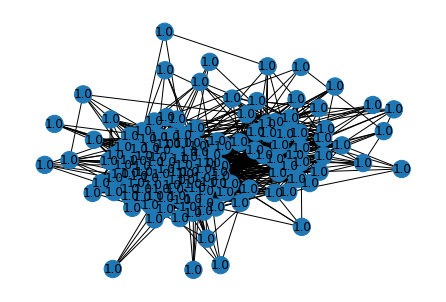

11


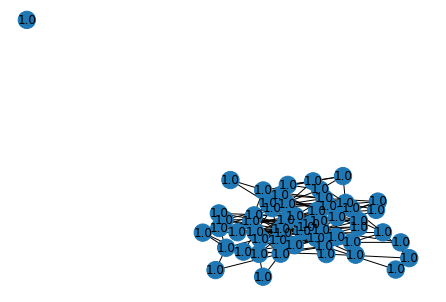

12


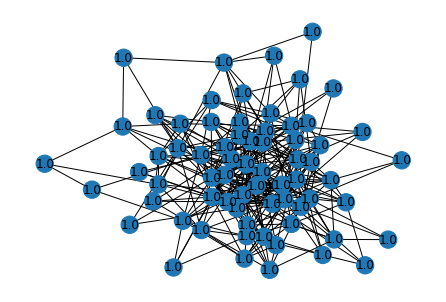

13


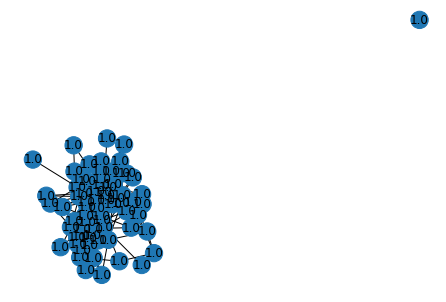

14


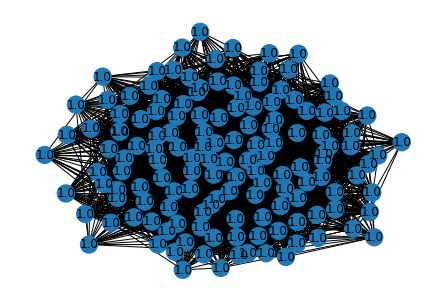

15


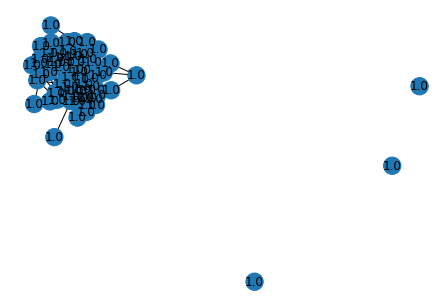

16


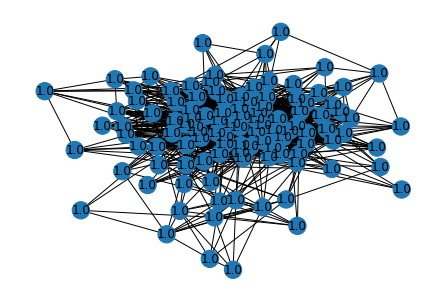

17


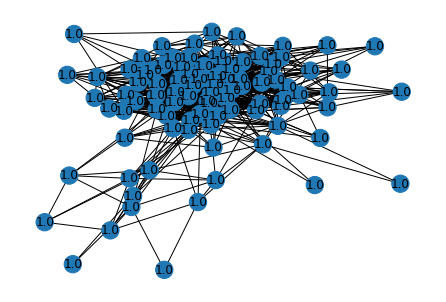

18


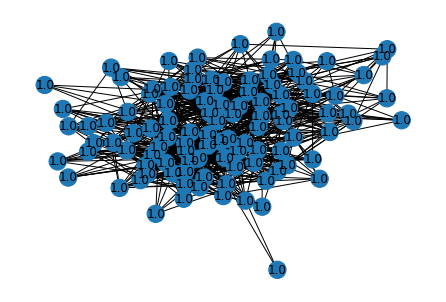

19


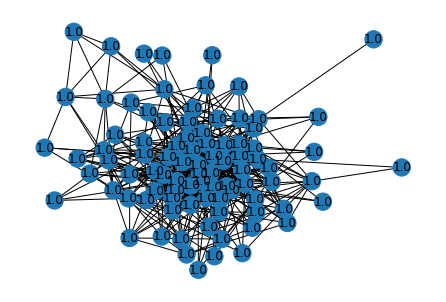

20


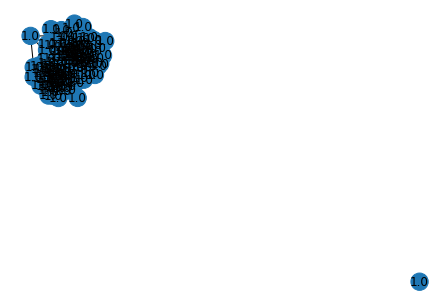

21


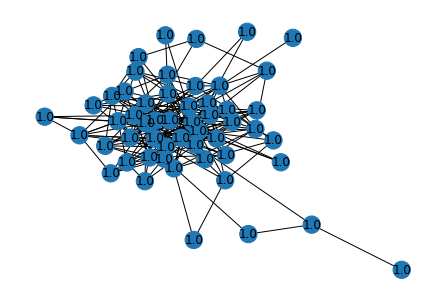

22


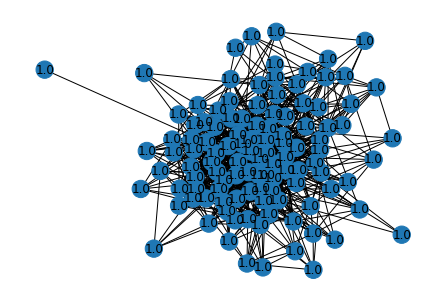

23


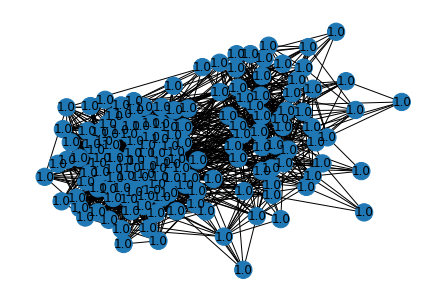

24


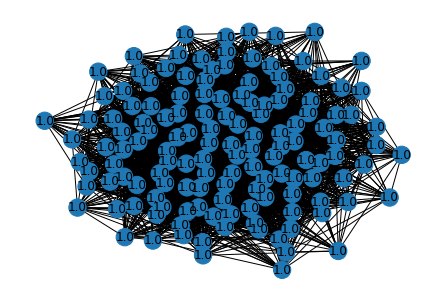

25


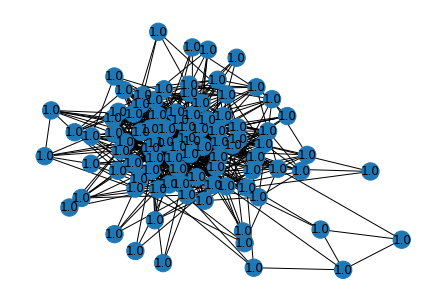

26


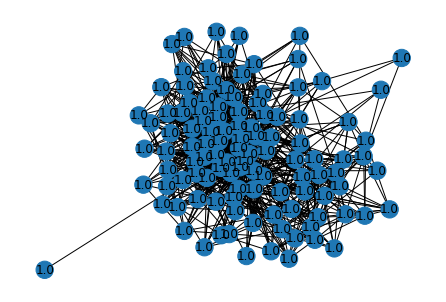

27


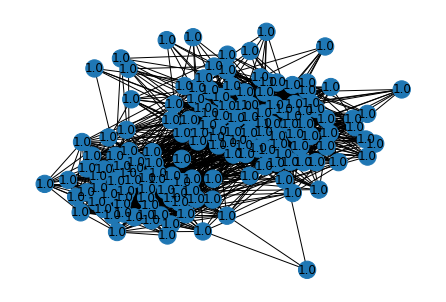

28


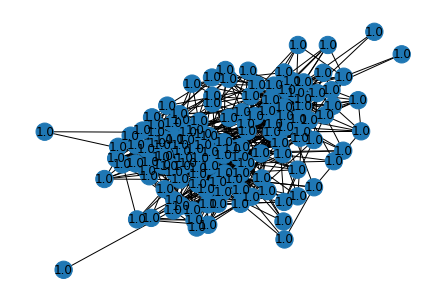

29


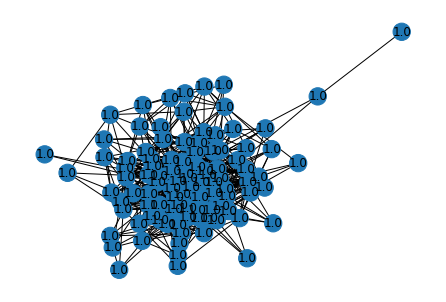

30


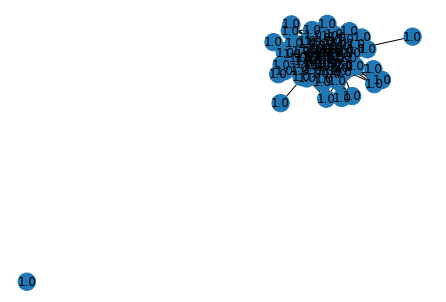

31


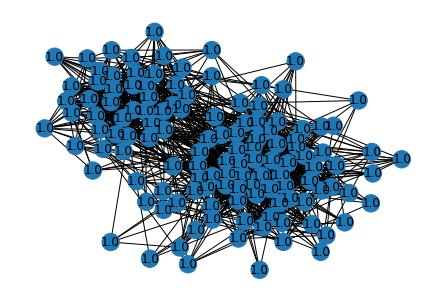

In [11]:
# Plot some randomly generated graphs
for i in range(len(graph_samples[-1])):
    print(i)
    g = graph_samples[-1][i]
    degrees = dict(g.degree())
    node_degrees = [degrees[n] for n in range(len(g))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(g), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(g, node_color=[round(labels[i]) for i in range(len(labels))], labels=labels, cmap="tab10")
    plt.show()

50


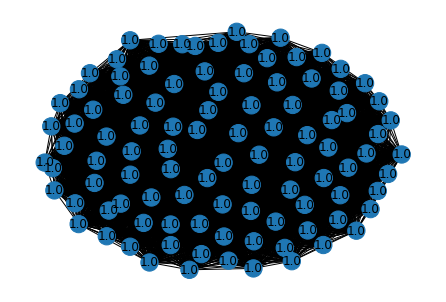

48


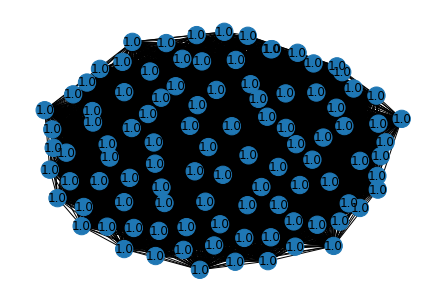

46


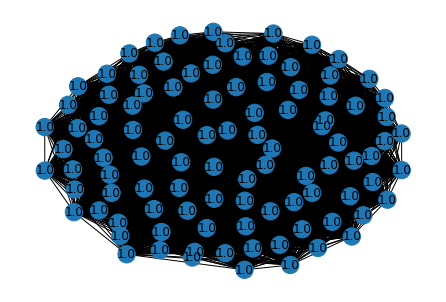

44


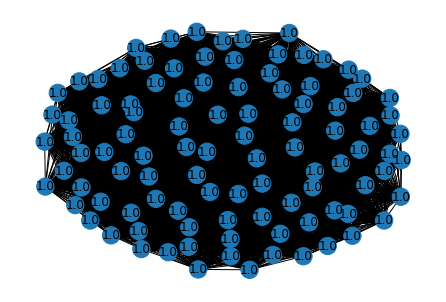

42


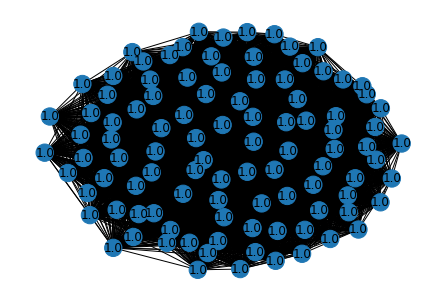

40


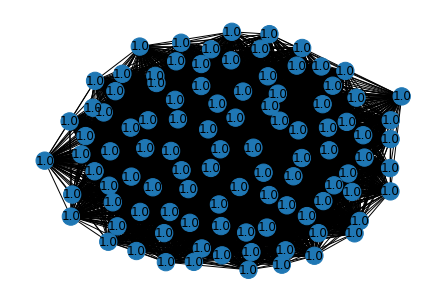

38


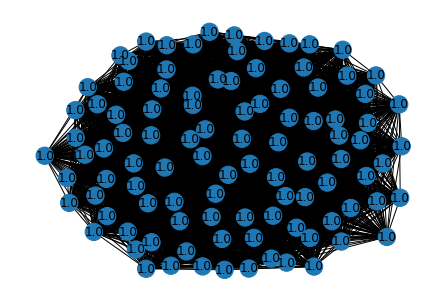

36


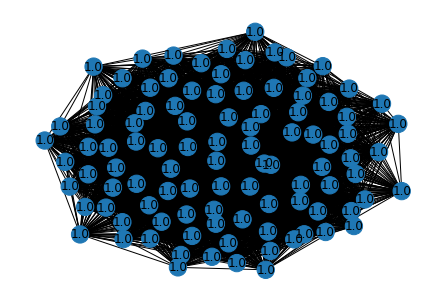

34


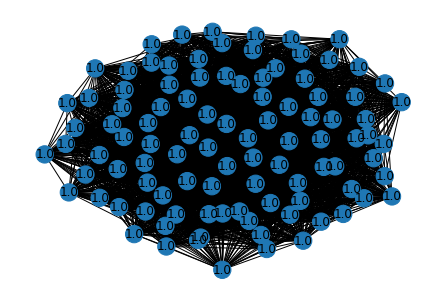

32


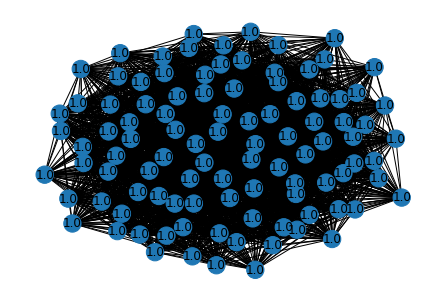

30


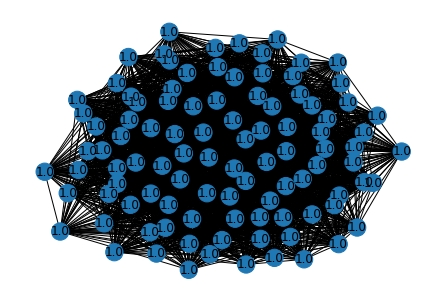

28


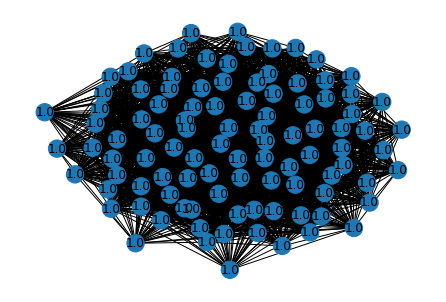

26


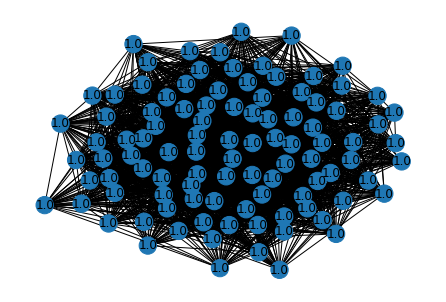

24


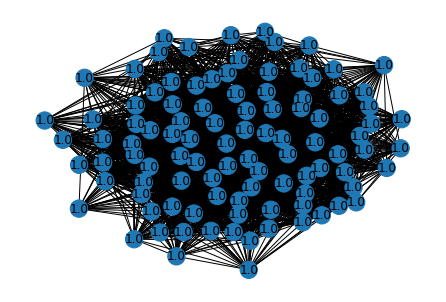

22


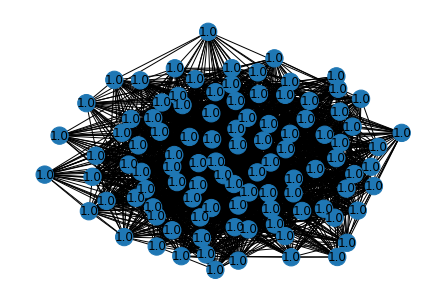

20


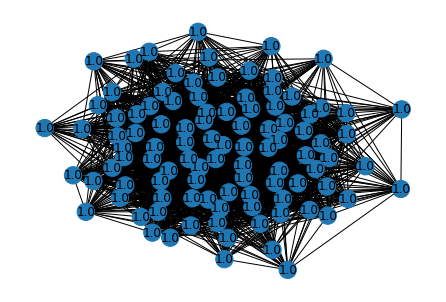

18


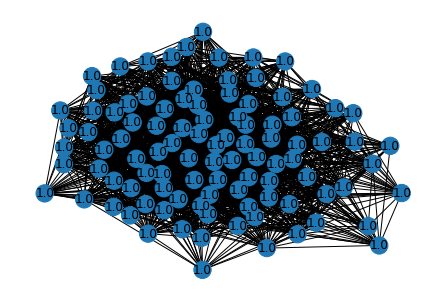

16


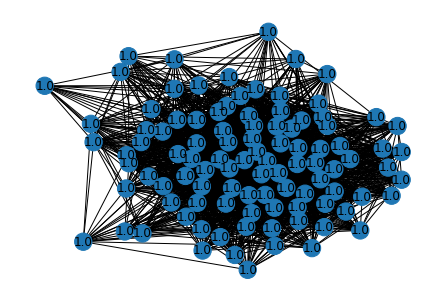

14


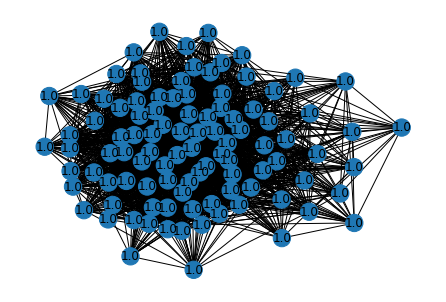

12


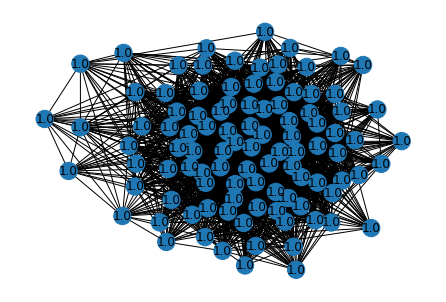

10


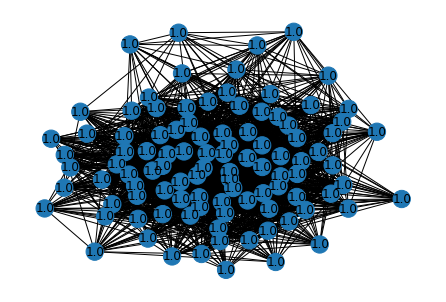

8


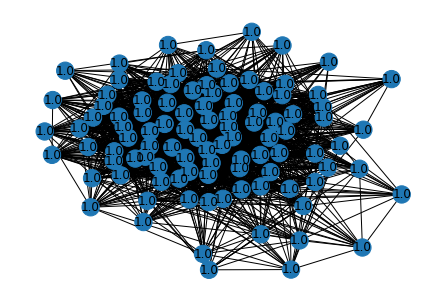

6


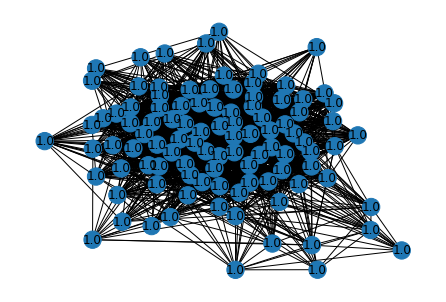

4


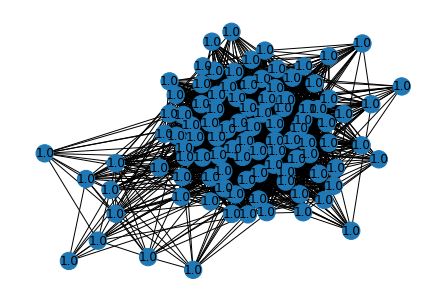

2


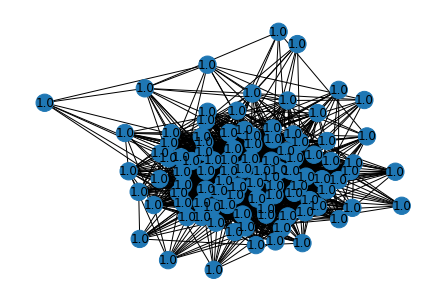

0


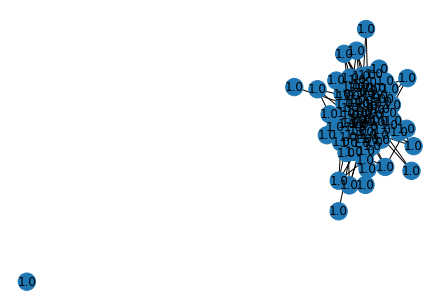

In [12]:
i = 30
num_to_show = 20
time_inds = np.arange(0, len(times), len(times) // num_to_show)
time_inds[-1] = len(times) - 1
for t_i in time_inds:
    print(times[t_i])
    g = graph_samples[t_i][i]
    degrees = dict(g.degree())
    node_degrees = [degrees[n] for n in range(len(g))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(g), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(g, node_color=[round(labels[i]) for i in range(len(labels))], labels=labels, cmap="tab10")
    plt.show()

In [13]:
# Compute various metrics comparing training and sampling distributions
train_graphs_1 = graph_samples[0]
train_graphs_2 = graph_conversions.split_pyg_data_to_nx_graphs(next(iter(data_loader)))
gen_graphs = graph_samples[-1]

square_func = np.square

gen_graphs = [nx.erdos_renyi_graph(100, 0.5) for _ in range(32)]

num_train_graphs_1, num_train_graphs_2, num_gen_graphs = len(train_graphs_1), len(train_graphs_2), len(gen_graphs)
all_graphs = train_graphs_1 + train_graphs_2 + gen_graphs

kernel_type = "gaussian_total_variation"

degree_hists = mmd.make_histograms(graph_metrics.get_degrees(all_graphs), bin_width=1)
degree_mmd_1 = square_func(mmd.compute_maximum_mean_discrepancy(
    degree_hists[:num_train_graphs_1], degree_hists[-num_gen_graphs:],
    kernel_type, sigma=1
))
degree_mmd_2 = square_func(mmd.compute_maximum_mean_discrepancy(
    degree_hists[:num_train_graphs_1], degree_hists[num_train_graphs_1:-num_gen_graphs],
    kernel_type, sigma=1
))
print("Degree MMD ratio: %.4f/%.4f = %.4f" % (degree_mmd_1, degree_mmd_2, degree_mmd_1 / degree_mmd_2))

cluster_coef_hists = mmd.make_histograms(graph_metrics.get_clustering_coefficients(all_graphs), num_bins=100)
cluster_coef_mmd_1 = square_func(mmd.compute_maximum_mean_discrepancy(
    cluster_coef_hists[:num_train_graphs_1], cluster_coef_hists[-num_gen_graphs:],
    kernel_type, sigma=0.1
))
cluster_coef_mmd_2 = square_func(mmd.compute_maximum_mean_discrepancy(
    cluster_coef_hists[:num_train_graphs_1], cluster_coef_hists[num_train_graphs_1:-num_gen_graphs],
    kernel_type, sigma=0.1
))
print("Clustering coefficient MMD ratio: %.4f/%.4f = %.4f" % (cluster_coef_mmd_1, cluster_coef_mmd_2, cluster_coef_mmd_1 / cluster_coef_mmd_2))

spectra_hists = mmd.make_histograms(graph_metrics.get_spectra(all_graphs), bin_array=np.linspace(-1e-5, 2, 200 + 1))
spectra_mmd_1 = square_func(mmd.compute_maximum_mean_discrepancy(
    spectra_hists[:num_train_graphs_1], spectra_hists[-num_gen_graphs:],
    kernel_type, sigma=1
))
spectra_mmd_2 = square_func(mmd.compute_maximum_mean_discrepancy(
    spectra_hists[:num_train_graphs_1], spectra_hists[num_train_graphs_1:-num_gen_graphs],
    kernel_type, sigma=1
))
print("Spectrum MMD ratio: %.4f/%.4f = %.4f" % (spectra_mmd_1, spectra_mmd_2, spectra_mmd_1 / spectra_mmd_2))

orbit_counts = graph_metrics.get_orbit_counts(all_graphs)
orbit_counts = np.stack([np.mean(counts, axis=0) for counts in orbit_counts])
orbit_mmd_1 = square_func(mmd.compute_maximum_mean_discrepancy(
    orbit_counts[:num_train_graphs_1], orbit_counts[-num_gen_graphs:],
    kernel_type, normalize=False, sigma=30
))
orbit_mmd_2 = square_func(mmd.compute_maximum_mean_discrepancy(
    orbit_counts[:num_train_graphs_1], orbit_counts[num_train_graphs_1:-num_gen_graphs],
    kernel_type, normalize=False, sigma=30
))
print("Orbit MMD ratio: %.4f/%.4f = %.4f" % (orbit_mmd_1, orbit_mmd_2, orbit_mmd_1 / orbit_mmd_2))

Degree MMD ratio: 0.3671/0.3352 = 1.0954
Clustering coefficient MMD ratio: 1.2196/1.0457 = 1.1662
Spectrum MMD ratio: 0.5253/0.4676 = 1.1233
Orbit MMD ratio: 0.0706/0.0787 = 0.8965
